In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings(action='ignore')

# Text processing and vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Pipeline and transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

In [2]:
covid_clean =pd.read_csv(r'/Users/eeshanimaheshgundi/Downloads/covid_ml.csv')

In [3]:
custom_stopwords = nltk.corpus.stopwords.words('english')

stopword_list = ['moderna', 'flu', 'mrna', 'vaccine', 'the', 'patient', 'pfizer', 
                 'biontech', 'nan', 'none', 'mg', 'medical', 'history', 'allergy', 
                 'year', 'old','uk','nkda','nka','known','reported','listed']

In [4]:
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,\
                                 token_pattern=r"(?u)\b\w+\b",\
                                 stop_words=stopword_list,
                                 ngram_range=(2, 2),max_features=5000))])

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Define preprocessing (only existing columns)
numeric_features = ['AGE_YRS', 'HOSPDAYS']   
categorical_features = ['SEX']
text_feature = 'SYMPTOM_TEXT'

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
text_transformer = TfidfVectorizer(max_features=1000, stop_words='english')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_feature)
    ],
    remainder='drop'
)


In [6]:
tfidfprocess = ColumnTransformer(transformers=[('text1', textTransformer_0, 'SYMPTOM_TEXT'),
                                              ('text2', textTransformer_0, 'OTHER_MEDS'),
                                              ('text3', textTransformer_0, 'CUR_ILL'),
                                              ('text4', textTransformer_0, 'HISTORY'),
                                              ('text5', textTransformer_0, 'ALLERGIES')
],remainder='passthrough')

In [7]:

# ===============================

import gc

# Step 1 — Downsample to make COVID dataset manageable (optional but recommended)
# Comment this out if you want full dataset
covid_clean = covid_clean.sample(frac=0.2, random_state=42)  # use 20% for faster model runs

# Step 2 — Handle missing/unknown manufacturer entries
covid_clean['VAX_MANU'] = covid_clean['VAX_MANU'].fillna('UNKNOWN')

# Step 3 — Create dummy variables safely (no merge)
vaccine_data = pd.get_dummies(covid_clean['VAX_MANU'], prefix='', prefix_sep='')

# Step 4 — Drop old column and concat encoded data
covid_clean = covid_clean.drop(columns=['VAX_MANU'], errors='ignore')
covid_clean = pd.concat([covid_clean, vaccine_data], axis=1)

# Step 5 — Clean and standardize column names
covid_clean.rename(columns={
    'PFIZER/BIONTECH': 'PFIZER',
    'MODERNA': 'MODERNA',
    'JANSSEN': 'JANSSEN',
    'NOVAVAX': 'NOVAVAX'
}, inplace=True)

# Step 6 — Ensure numeric consistency for later steps
for col in ['NUMDAYS', 'HOSPDAYS']:
    if col not in covid_clean.columns:
        covid_clean[col] = 0

# Step 7 — Garbage collect to free memory
gc.collect()

print(f"✅ Vaccine encoding complete. Current columns: {list(vaccine_data.columns)}")
print(f"Dataset shape after encoding: {covid_clean.shape}")



✅ Vaccine encoding complete. Current columns: ['JANSSEN', 'MODERNA', 'NOVAVAX', 'PFIZER\\BIONTECH']
Dataset shape after encoding: (221454, 28)


In [8]:
covid_clean.OTHER_MEDS = covid_clean.OTHER_MEDS.replace(np.nan,'',regex=True)
covid_clean.CUR_ILL = covid_clean.CUR_ILL.replace(np.nan,'',regex=True)
covid_clean.HISTORY = covid_clean.HISTORY.replace(np.nan,'',regex=True)
covid_clean.ALLERGIES = covid_clean.ALLERGIES.replace(np.nan,'',regex=True)
covid_clean = covid_clean.sample(frac=0.15, random_state=42)

     

In [10]:

from sklearn.model_selection import train_test_split

# Define target variable
y = covid_clean['SERIOUS']

# Define feature matrix
X = covid_clean.drop(
    ['SERIOUS','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5','VAX_MANU'],
    axis=1, errors='ignore'
)

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=200, stratify=y
)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')


Training examples: 23,252
Test examples: 9,966


In [11]:
pipeline_logistic = Pipeline([
    ('tfidf', tfidfprocess),  # Use the TF-IDF transformer
    ('classifier', LogisticRegression(max_iter=1000,class_weight='balanced', random_state=200))
])

In [12]:
pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text1',
                                                  Pipeline(steps=[('text_bow',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                                                               'nan',
                                                                                               'none',
                                                                                               'mg',
                                                                                               'medical',
                                                                                               'history',
                                                                                               'allergy',
                                                                                               'year',
                                                                                               'old',
                                                                                               'uk',
                                                                                               'nkda',
                                                                                               'nka',
                                                                                               'known',
                                                                                               'reported',
                                                                                               '...
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                      

In [13]:
# Predict on the test data
y_pred_log = pipeline_logistic.predict(X_test)

\n=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7153
           1       0.78      0.83      0.80      2813

    accuracy                           0.88      9966
   macro avg       0.85      0.87      0.86      9966
weighted avg       0.89      0.88      0.88      9966

Accuracy: 0.8837 | ROC-AUC: 0.9414 | PR-AUC: 0.9004


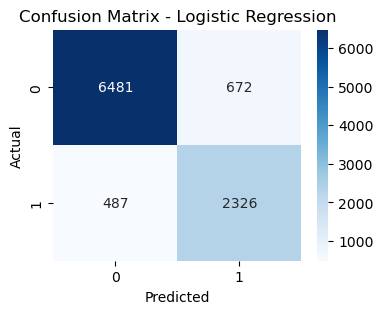

\n=== Random Forest ===
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      7153
           1       0.74      0.75      0.75      2813

    accuracy                           0.86      9966
   macro avg       0.82      0.82      0.82      9966
weighted avg       0.86      0.86      0.86      9966

Accuracy: 0.8554 | ROC-AUC: 0.9023 | PR-AUC: 0.8437


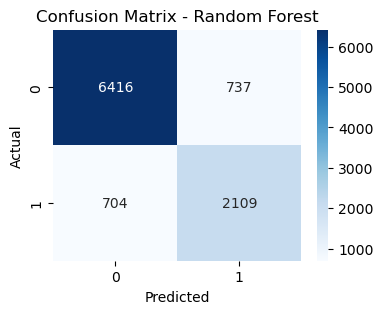

\n=== XGBoost ===
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7153
           1       0.93      0.67      0.78      2813

    accuracy                           0.89      9966
   macro avg       0.91      0.82      0.85      9966
weighted avg       0.90      0.89      0.89      9966

Accuracy: 0.8924 | ROC-AUC: 0.9346 | PR-AUC: 0.8964


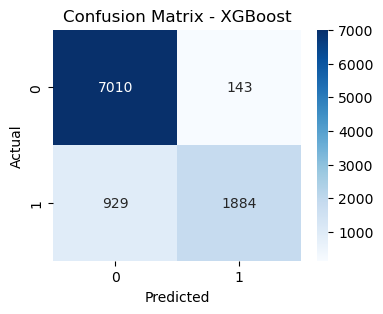

\nModel Comparison Summary:


,Model,Accuracy,ROC-AUC,PR-AUC
0,Logistic Regression,0.883705,0.941402,0.900445
1,Random Forest,0.855408,0.902345,0.843709
2,XGBoost,0.892434,0.934587,0.896371


In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,        # ↓ from 200
        max_depth=10,           # cap depth
        class_weight='balanced',
        random_state=42,
        n_jobs=-1               # use all CPU cores
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,       # ↓ from 300
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=2,               # limit threads for stability
        eval_metric='logloss',
        use_label_encoder=False
    )
}


results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    print(f"\\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    results.append((name, acc, roc_auc, pr_auc))

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'ROC-AUC', 'PR-AUC'])
print("\\nModel Comparison Summary:")
display(results_df)

In [16]:
import time

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    matthews_corrcoef
)

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Track training time
    start_train = time.time()
    pipeline.fit(X_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train

    # Track prediction time
    start_pred = time.time()
    y_pred = pipeline.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred

    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"Training time: {training_time:.2f} sec | Prediction time: {prediction_time:.2f} sec")

    results.append((name, acc, precision, recall, f1, roc_auc, pr_auc, mcc, training_time, prediction_time))

results_df = pd.DataFrame(results, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
    'ROC-AUC', 'PR-AUC', 'MCC', 'Train Time (s)', 'Predict Time (s)'
])

display(results_df.sort_values(by='ROC-AUC', ascending=False))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7153
           1       0.78      0.83      0.80      2813

    accuracy                           0.88      9966
   macro avg       0.85      0.87      0.86      9966
weighted avg       0.89      0.88      0.88      9966

Accuracy: 0.8837 | ROC-AUC: 0.9414 | PR-AUC: 0.9004
Training time: 0.79 sec | Prediction time: 0.28 sec

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      7153
           1       0.74      0.75      0.75      2813

    accuracy                           0.86      9966
   macro avg       0.82      0.82      0.82      9966
weighted avg       0.86      0.86      0.86      9966

Accuracy: 0.8554 | ROC-AUC: 0.9023 | PR-AUC: 0.8437
Training time: 0.86 sec | Prediction time: 0.29 sec

=== XGBoost ===
              precision    recall  f1-score   support

           0  

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,MCC,Train Time (s),Predict Time (s)
0,Logistic Regression,0.883705,0.775851,0.826875,0.800551,0.941402,0.900445,0.719318,0.785485,0.280987
2,XGBoost,0.892434,0.929452,0.669748,0.778512,0.934587,0.896371,0.726557,3.098749,0.280707
1,Random Forest,0.855408,0.741040,0.749733,0.745361,0.902345,0.843709,0.644428,0.856115,0.286147


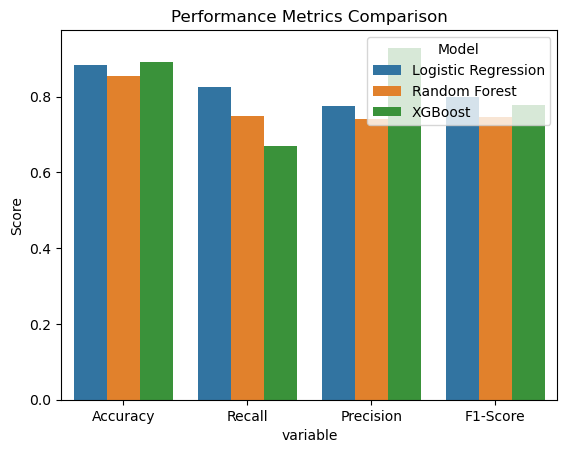

In [17]:
sns.barplot(data=results_df.melt(id_vars='Model',
            value_vars=['Accuracy','Recall','Precision','F1-Score']),
            x='variable', y='value', hue='Model')
plt.title("Performance Metrics Comparison")
plt.ylabel("Score")
plt.show()

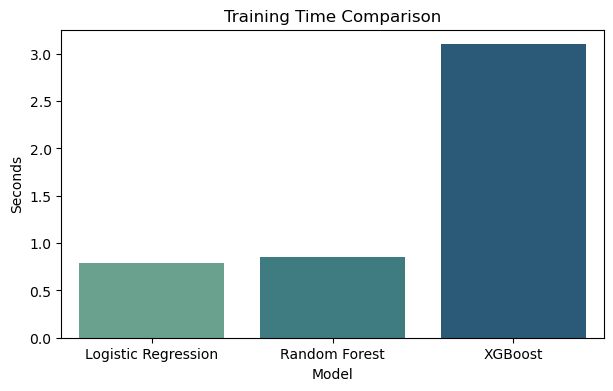

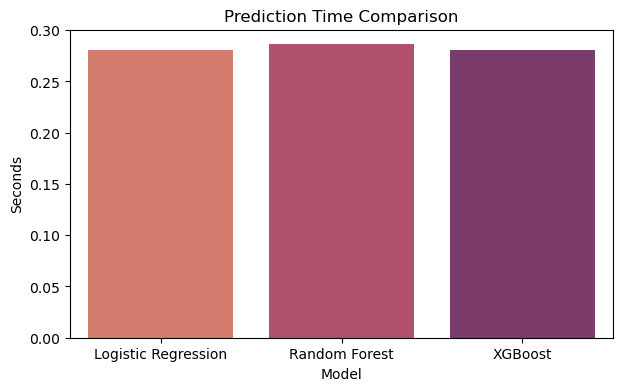

In [18]:
# 🔹 Plot Training Time Comparison
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x='Model', y='Train Time (s)', palette='crest')
plt.title('Training Time Comparison')
plt.ylabel('Seconds')
plt.show()

# 🔹 Plot Prediction Time Comparison
plt.figure(figsize=(7,4))
sns.barplot(data=results_df, x='Model', y='Predict Time (s)', palette='flare')
plt.title('Prediction Time Comparison')
plt.ylabel('Seconds')
plt.show()

In [19]:
fastest_train = results_df.loc[results_df['Train Time (s)'].idxmin(), 'Model']
fastest_predict = results_df.loc[results_df['Predict Time (s)'].idxmin(), 'Model']

print(f"⚡ Fastest to train: {fastest_train}")
print(f"⚡ Fastest to predict: {fastest_predict}")

⚡ Fastest to train: Logistic Regression
⚡ Fastest to predict: XGBoost
